In [2]:
import jax.numpy as jnp
import numpy as np
import jax.ops as ops
from jax import grad, jit, vmap
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import cmasher as cmr

In [3]:
# Differentiate cosine
my_sin = grad(jnp.cos)
x = jnp.pi/2
y = jnp.cos(x)
dydx = my_sin(x)

print(f'y = cos(x)\nfor x = {x:.2f}:')
print(f'\ty = {y:.2f}\n\tdydx = {dydx:.2f}')

y = cos(x)
for x = 1.57:
	y = -0.00
	dydx = -1.00


In [4]:
# Differentiate 2nd order polynomial, scalar
def my_quad(x, p):
  assert len(p) == 3
  return p[0] + p[1]*x + p[2]*x**2

x = 1.0
p = jnp.array([1.0,2.0,3.0])
y = my_quad(x,p)
my_lin = grad(my_quad)
dydx = my_lin(x,p)

print(f'quadratic equation, y = p0 + p1*x + p2*x^2\nfor x = {x:.2f}, p = {p}:')
print(f'\ty = {y:.2f}\n\tdydx = {dydx:.2f}')

quadratic equation, y = p0 + p1*x + p2*x^2
for x = 1.00, p = [1. 2. 3.]:
	y = 6.00
	dydx = 8.00


In [5]:
# Differentiate 2nd order polynomial, vector
x_vec = jnp.arange(0.0, 1.2, 0.2)
y_vec = vmap(my_quad, in_axes=(0,None))(x_vec, p)
dydx_vec = vmap(my_lin, in_axes=(0,None))(x_vec, p)

print(f'Using y and p as defined above\nfor x = {x_vec}:')
print(f'\ty =    {y_vec}')
print(f'\tdydx = {dydx_vec}')

Using y and p as defined above
for x = [0.  0.2 0.4 0.6 0.8 1. ]:
	y =    [1.        1.52      2.28      3.2800002 4.52      6.       ]
	dydx = [2.        3.2       4.4       5.6000004 6.8       8.       ]


In [6]:
def V(dx, k):
  ''' Potential energy of deformation of spring between masses n and n+1,
      with spring constant k and deformation dx = x_n+1 - x_n '''
  return 0.5*k*dx**2


def T(p, m):
  ''' Kinetic energy of mass m with momentum p '''
  return 0.5*p**2/m


def H(x, p, params):
  ''' Given positions x and momentums p, compute Hamiltonian of system with N masses.
      Dictionary params includes stiffness k, mass m, and boundary condition BC
      defines right edge of chain '''

  if params['BC'] == 0: # free
    dx = jnp.pad(jnp.diff(x),(0,1),'constant')
  elif params['BC'] == 1: #fixed
    dx = jnp.diff(jnp.pad(x,(0,1),'constant'))
  else:
    assert False, 'Specify right boundary condition as 0 (free) or 1 (fixed)'

  V_vec = vmap(V, in_axes=(0,None))(dx, params['k'])
  T_vec = vmap(T, in_axes=(0,None))(p, params['m'])
  H_total = jnp.sum(jnp.add(V_vec, T_vec))

  return H_total

In [7]:
dHdx = grad(H, argnums=0)
dHdp = grad(H, argnums=1)

def eom(t, y, params):
  ''' Equations of motion for general 1D Hamiltonian with N units '''

  x, p = jnp.split(y, 2, axis=0)
  dxdt =  dHdp(x, p, params) # velocity
  dpdt = -dHdx(x, p, params) # force
  dydt = jnp.concatenate((dxdt,dpdt), axis=0)

  return dydt

In [8]:
def generate_IC_vector(x0, p0):
  ''' Given inital position x0 and momentum p0 of the leftmost unit of a single mass spring
      chain, return y0 vector containing initial x and p vectors assuming the
      remaining masses are at rest in equilibrium.
      
      For use in solve_ivp, need y0.shape = (2N,)'''

  x = jnp.zeros(1)
  p = jnp.zeros(1)
  #x = ops.index_update(x, 0, x0)
  #p = ops.index_update(p, 0, p0)
  x = x.at[0].set(x0) #ops.index_update(x, 0, x0)
  p = p.at[0].set(p0) #ops.index_update(p, 0, p0)
  y0 = jnp.concatenate((x,p), axis=0)

  return y0

In [9]:
params = {'k':10, 'm':10, 'BC':1} # {k: spring constant, m: mass, BC: [0|1]}
x0 = 0.0 # Initially in equilibrium position
p0 = 1.0 # Give initial "kick" to left end
y0 = generate_IC_vector(x0, p0)
print(f'IC vector is {y0}')

IC vector is [0. 1.]


In [10]:
# Set the solver parameters and simulation time
tspan = (0.0,50.0)
method = 'RK45' # Typical Runge-Kutta method
rtol = 1e-8
atol = 1e-8

In [11]:
# Solve equations of motion 
sol = solve_ivp(eom, tspan, y0, method=method, rtol=rtol, atol=atol, args=(params,))

print('Solution found over {0} time steps'.format(len(sol.t)))

Solution found over 411 time steps


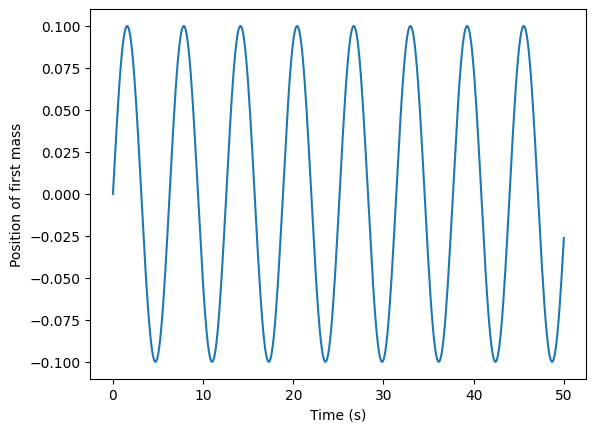

In [12]:
# Plot displacement of first mass over simulation time
plt.figure('solution')
plt.plot(sol.t, sol.y[0])
plt.xlabel('Time (s)')
plt.ylabel('Position of first mass')

x_arr, p_arr = jnp.split(sol.y, 2, axis=0)

Maximum energy difference    = 5.2154e-08
Maximum energy error         = 1.0431e-06


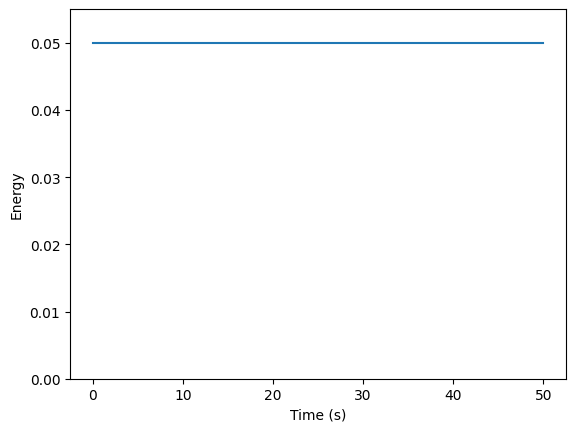

In [13]:
# Quality check: find and plot total energy over simulation time
H_total = vmap(H, in_axes=(1,1,None))(x_arr, p_arr, params)

plt.figure('H_over_time')
plt.plot(sol.t, H_total)
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.ylim(0, 1.1*max(H_total))

print('Maximum energy difference    = {0:.4e}'.format( (max(H_total)-min(H_total)) ))
print('Maximum energy error         = {0:.4e}'.format( (max(H_total)-min(H_total))/jnp.mean(H_total) ))

In [14]:
# Create data
k = [1]#, 2, 4, 8, 16]
m = [2]#, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

count = 0
for i in range(len(k)):
    for j in range(len(m)):
        count += 1
        print(f"at trial {count} of {len(k)*len(m)}")
        params = {'k':k[i], 'm':m[j], 'BC':1} # {k: spring constant, m: mass, BC: [0|1]}
        x0 = 0.0 # Initially in equilibrium position
        p0 = 1.0 # Give initial "kick" to left end
        y0 = generate_IC_vector(x0, p0)
        # Set the solver parameters and simulation time
        tspan = (0.0,200.0)
        method = 'RK45' # Typical Runge-Kutta method
        rtol = 1e-8
        atol = 1e-8
        sol = solve_ivp(eom, tspan, y0, method=method, rtol=rtol, atol=atol, args=(params,))
        solution = jnp.array([sol.t, sol.y[0]])
        trial_name = 'spring_data/trial_k' + str(params['k']) + '_m' + str(params['m']) + '.npy'
        np.save(trial_name, solution)

at trial 1 of 1
